In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [4]:
%%time
test = pd.read_csv('test.csv', index_col = 0)
train = pd.read_csv('train.csv', index_col = 0)
# train.head()
# train.info()
# test.info()
### encode values: Sex
train.Sex = train.Sex.apply(lambda x: 1 if x=='male' else 0)
test.Sex = test.Sex.apply(lambda x: 1 if x=='male' else 0)

### impute missing or zero Fare values with median Fares for each Pclass
train.loc[(train.Fare==0)&(train.Pclass==1),"Fare"] = train[(train['Fare']!=0)]\
                                                                .groupby('Pclass')['Fare'].describe()['50%'][1]
train.loc[(train.Fare==0)&(train.Pclass==2),"Fare"] = train[(train['Fare']!=0)]\
                                                                .groupby('Pclass')['Fare'].describe()['50%'][2]

train.loc[(train.Fare==0)&(train.Pclass==3),"Fare"] = train[(train['Fare']!=0)]\
                                                                .groupby('Pclass')['Fare'].describe()['50%'][3]

test.loc[((pd.isnull(test['Fare'])==True)|(test.Fare==0))&(test.Pclass==1),"Fare"] = train[(train['Fare']!=0)]\
                                                                .groupby('Pclass')['Fare'].describe()['50%'][1]
test.loc[((pd.isnull(test['Fare'])==True)|(test.Fare==0))&(test.Pclass==2),"Fare"] = train[(train['Fare']!=0)]\
                                                                .groupby('Pclass')['Fare'].describe()['50%'][2]

test.loc[((pd.isnull(test['Fare'])==True)|(test.Fare==0))&(test.Pclass==3),"Fare"] = train[(train['Fare']!=0)]\
                                                                .groupby('Pclass')['Fare'].describe()['50%'][3]

# extract titles from names
def title_extractor(row):
    return row.split(',')[1].strip().split('.')[0]
titles_train = train.Name.apply(title_extractor)
titles_test = test.Name.apply(title_extractor)
titles_train = titles_train.map({'Mr':'Mr','Mrs':'Mrs','Miss':'Miss','Master':'Master','Dr':'Dr','Rev':'Rev',
                                   'Don':'Mr', 'Mlle':'Miss', 'Lady':'Mrs', 'Ms':'Mrs', 
                                   'Mme':'Mrs', 'the Countess': 'Mrs', 'Col':'Mr','Major':'Mr',
                                  'Sir':'Mr','Jonkheer':'Mr','Capt':'Mr'})
titles_test = titles_test.map({'Mr':'Mr','Mrs':'Mrs','Miss':'Miss','Master':'Master','Dr':'Dr','Rev':'Rev',
                                   'Don':'Mr', 'Mlle':'Miss', 'Lady':'Mrs', 'Ms':'Mrs', 
                                   'Mme':'Mrs', 'the Countess': 'Mrs', 'Col':'Mr','Major':'Mr',
                                  'Sir':'Mr','Jonkheer':'Mr','Capt':'Mr',
                              'Dona':'Mrs'})

if 'Title' not in train.columns:
    train['Title'] = titles_train
    title_encoded_train = pd.get_dummies(train.Title, prefix_sep = '_', drop_first = True)
    train = pd.concat([train, title_encoded_train], axis = 1)
if 'Title' not in test.columns:
    test['Title'] = titles_test
    title_encoded_test = pd.get_dummies(test.Title, prefix_sep = '_', drop_first = True)
    test = pd.concat([test, title_encoded_test], axis = 1)

#encode port of embarkation
train = pd.concat([train, pd.get_dummies(train.Embarked, prefix_sep = '_', drop_first = True)], axis = 1)
test = pd.concat([test, pd.get_dummies(test.Embarked, prefix_sep = '_', drop_first = True)], axis = 1)

# add Family size, IsAlone and Has_Cabin

train['FamilySize'] = train['Parch'] + train['SibSp'] + 1
test['FamilySize'] = test['Parch'] + test['SibSp'] + 1
train['IsAlone'] = (train['FamilySize'] == 1).astype(np.int8)
test['IsAlone'] = (test['FamilySize'] == 1).astype(np.int8)
train['HasCabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['HasCabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

    #categorical columns
col_types = train.dtypes.to_frame().reset_index()
cat_cols = col_types.loc[col_types[0]=='object']['index']
cat_cols

### ### impute Age by prediction with random forest regressor
#y and X sets for Age
y_age = train[pd.isnull(train['Age'])==False]['Age']
X_age = train[pd.isnull(train['Age'])==False].drop(cat_cols,axis=1).drop(['Age','Survived'],axis=1)

#train and val split for Age 
X_age_train, X_age_val, y_age_train, y_age_val = train_test_split(X_age, y_age, test_size = 0.25, random_state = 21)

# select entries with missing Age
X_nullage = train[pd.isnull(train['Age'])==True].drop(cat_cols,axis=1).drop(['Age','Survived'],axis=1)

# instantiate random forest regressor
age_reg = RandomForestRegressor(max_depth=4, random_state=21)
age_reg.fit(X_age_train, y_age_train)

# predict age for train and val sets
y_age_train_pred = age_reg.predict(X_age_train)
y_age_val_pred = age_reg.predict(X_age_val)

# check mean square erorrs and compare to simple median age imputer
print(f'train age MSE: {mean_squared_error(y_age_train, y_age_train_pred)}')
print(f'valid age MSE: {mean_squared_error(y_age_val, y_age_val_pred)}')
print(f'median age MSE: {mean_squared_error(y_age_val, np.asarray([y_age.median() for i in range(len(y_age_val))]))}')

# predict misisng Age values
age_imputed = age_reg.predict(X_nullage)
# replace null Age with predictions
X_nullage['Age'] = age_imputed
train.Age.loc[X_nullage['Age'].index] = X_nullage['Age'].copy()

### test set age imputation
test_nullage = test[pd.isnull(test['Age'])==True].drop(cat_cols,axis=1).drop('Age',axis=1)
age_test_imputed = age_reg.predict(test[pd.isnull(test['Age'])==True].drop(cat_cols,axis=1).drop('Age',axis=1))
test_nullage['Age'] = age_test_imputed
test.Age.loc[test_nullage['Age'].index] = test_nullage['Age'].copy()

train age MSE: 108.90607454508152
valid age MSE: 116.78580854916186
median age MSE: 236.75963240223462
Wall time: 282 ms


C:\Users\pavlo\anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\pavlo\anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [23]:

titles_test.value_counts()
titles_train.value_counts()

Mr        525
Miss      184
Mrs       129
Master     40
Dr          7
Rev         6
Name: Name, dtype: int64

In [24]:
train[train.Pclass==3].Survived.sum()

119

<Figure size 432x216 with 0 Axes>

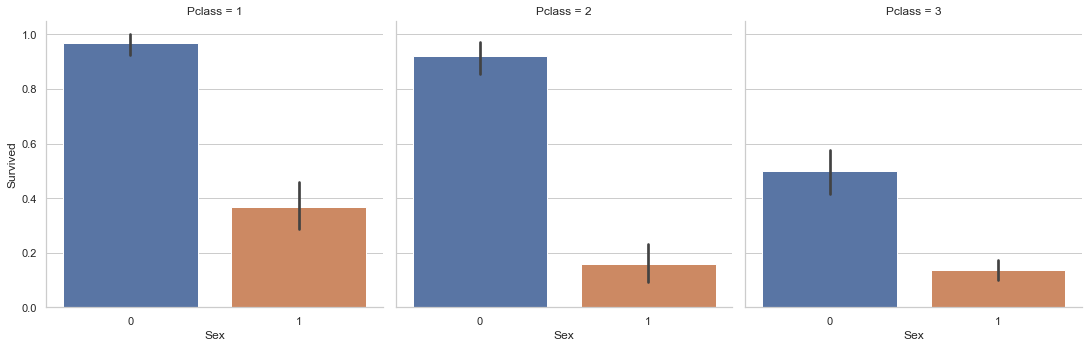

In [25]:
plt.figure(figsize=(6,3))
sns.set(style="whitegrid")
g = sns.catplot(y = 'Survived', x = 'Sex', col = 'Pclass', data = train, 
            kind = 'bar', col_wrap=5, legend=True)


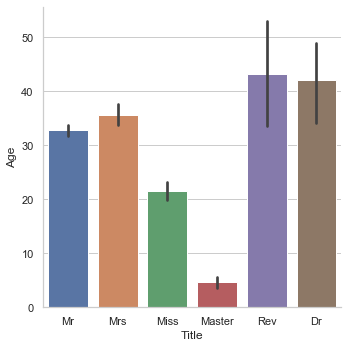

In [26]:

sns.catplot(y = 'Age', x = 'Title', data = train, kind = 'bar')

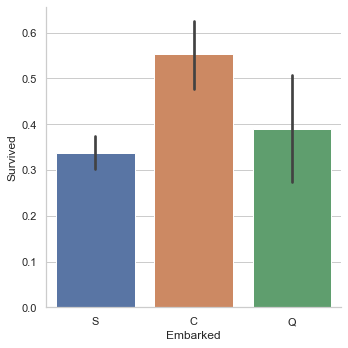

In [27]:
sns.catplot(y = 'Survived', x = 'Embarked', data = train, kind = 'bar')

In [28]:
train[train.Embarked=='Q'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 6 to 891
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  77 non-null     int64  
 1   Pclass    77 non-null     int64  
 2   Name      77 non-null     object 
 3   Sex       77 non-null     int64  
 4   Age       77 non-null     float64
 5   SibSp     77 non-null     int64  
 6   Parch     77 non-null     int64  
 7   Ticket    77 non-null     object 
 8   Fare      77 non-null     float64
 9   Cabin     4 non-null      object 
 10  Embarked  77 non-null     object 
 11  Title     77 non-null     object 
 12  Master    77 non-null     uint8  
 13  Miss      77 non-null     uint8  
 14  Mr        77 non-null     uint8  
 15  Mrs       77 non-null     uint8  
 16  Rev       77 non-null     uint8  
 17  Q         77 non-null     uint8  
 18  S         77 non-null     uint8  
dtypes: float64(2), int64(5), object(5), uint8(7)
memory usage: 8.3+ KB


<Figure size 432x216 with 0 Axes>

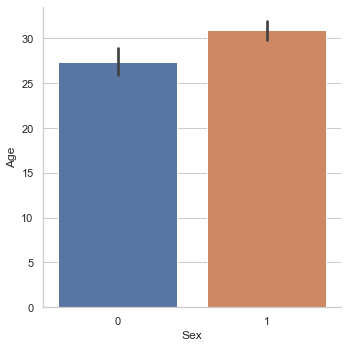

In [29]:
plt.figure(figsize=(6,3))
sns.set(style="whitegrid")
sns.catplot(y = 'Age', x = 'Sex', data = train, kind = 'bar')

train score: 0.875748502994012
valid score: 0.820627802690583


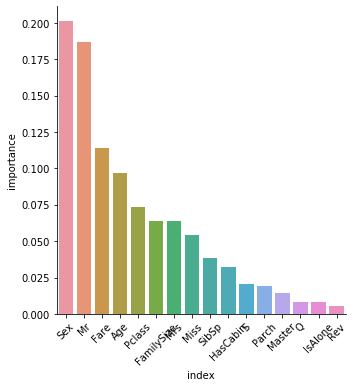

In [8]:
### fitting model
X, y = train.drop(['Survived'], axis = 1), train['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 21)
clf = RandomForestClassifier(max_depth=6, random_state=21)
clf.fit(X_train.drop(cat_cols, axis=1), y_train)

feature_importance = pd.DataFrame(clf.feature_importances_, 
                                  index = X_train.drop(cat_cols, axis=1).columns,
                                  columns = ['importance']
                                ).sort_values('importance', ascending = False).reset_index()
# print(feature_importance)
sns.catplot(y='importance', x='index', data = feature_importance, kind = 'bar').set_xticklabels(rotation=45)

print(f'train score: {clf.score(X_train.drop(cat_cols, axis=1), y_train)}') #0.83 with mean age imputer
print(f'valid score: {clf.score(X_val.drop(cat_cols, axis=1), y_val)}') #0.807175 mean age imputer for max_depth=4
test_predictions = clf.predict(test.drop(cat_cols,axis=1))#.drop('Survived',axis=1))



In [6]:
test_prediction = test.copy()
test_prediction['Survived'] = test_predictions
test_prediction['Survived'].to_csv('gender_submission_6.csv', header = True) 
### gets 0.79904 on public leaderboard on kaggle

In [32]:
test_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    int64  
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
 10  Title     418 non-null    object 
 11  Master    418 non-null    uint8  
 12  Miss      418 non-null    uint8  
 13  Mr        418 non-null    uint8  
 14  Mrs       418 non-null    uint8  
 15  Rev       418 non-null    uint8  
 16  Q         418 non-null    uint8  
 17  S         418 non-null    uint8  
 18  Survived  418 non-null    int64  
dtypes: float64(2), int64(5), object(5), uint8(7)
memory usage: 45.3+ KB
